# setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/UCL/STAT0035/bnn-regression')

In [3]:
%%capture
!pip install dm-haiku

In [4]:
# use TPUs
# - https://github.com/google/jax/pull/8485/commits/61a3abbeab027d0b4ad868de1cbb6a542cd19c4a
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu('tpu_driver-0.1dev20211031')

# use float32 matmul on TPU
import jax
jax.config.update('jax_default_matmul_precision', 'highest')

# check the number of GPU / TPU devices
n_dev = jax.local_device_count() 
print('num. devices:', n_dev)

num. devices: 8


# imports

In [6]:
# system imports
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pickle

# relative imports
from core import models, distributions, datasets, utils, metrics
from core.sgd import train_sgd, train_ensamble
from core.rwmh import rwmh_sampler
from core.hmc import hmc_sampler
from core.nuts import nuts_sampler
from core.spmd import pmap_

In [7]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# dataset

In [9]:
ds_path = 'naval_dataset/data.txt'
key = jax.random.PRNGKey(0)
(x_train, y_train), (x_test, y_test) = datasets.load_naval_dataset(ds_path, key)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(10740, 14) (10740,) (1194, 14) (1194,)


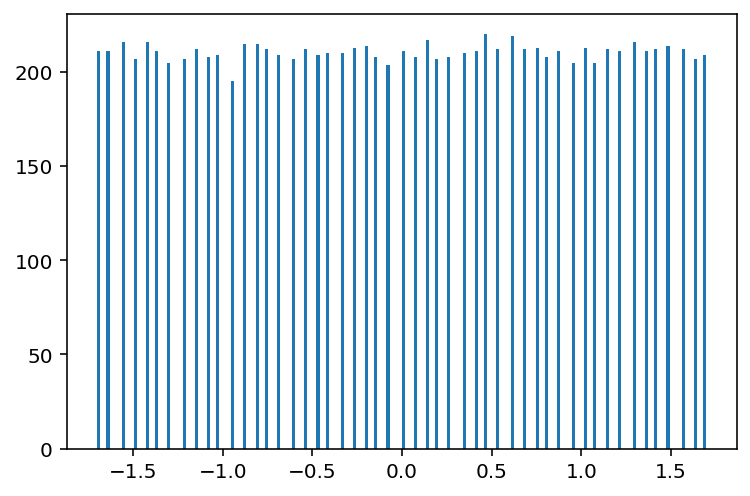

In [10]:
plt.hist(y_train, bins=200)
plt.show()

# model

In [20]:
# define model
key = jax.random.PRNGKey(0)
layer_dims = 1*[50]
prior_sd = 1
init_sd = 0.1
predict_fn, params_init = models.make_nn(key, x_train, layer_dims)
n_params = len(params_init)
params_init = init_sd*jax.random.normal(key, [n_params])
log_likelihood_fn = distributions.make_gaussian_log_likelihood(x_train, y_train, predict_fn)
log_prior_fn = distributions.make_gaussian_log_prior(prior_sd)
log_posterior_fn = distributions.make_log_posterior_fn(x_train, y_train, log_likelihood_fn, log_prior_fn)

In [12]:
# test model
print('num. params: ', n_params)
print('PDF test: ', log_prior_fn(params_init), log_likelihood_fn(params_init, x_train, y_train))

num. params:  852
PDF test:  -787.25104 -16492.633


# training

In [45]:
# number of samples to keep from each chain
n_samples = 100

## SGD

In [38]:
%%time
n_epochs = 100_000
lr_start = 1e-6
lr_stop = 1e-9
params_sgd, loss_sgd = pmap_(train_sgd)(x_train, y_train, params_init, log_likelihood_fn, log_prior_fn, n_dev, n_epochs, lr_start, lr_stop)
chain_sgd = params_sgd[None]
jnp.save('tmp/sgd.npy', chain_sgd)

CPU times: user 1.63 s, sys: 3.21 s, total: 4.84 s
Wall time: 7.93 s


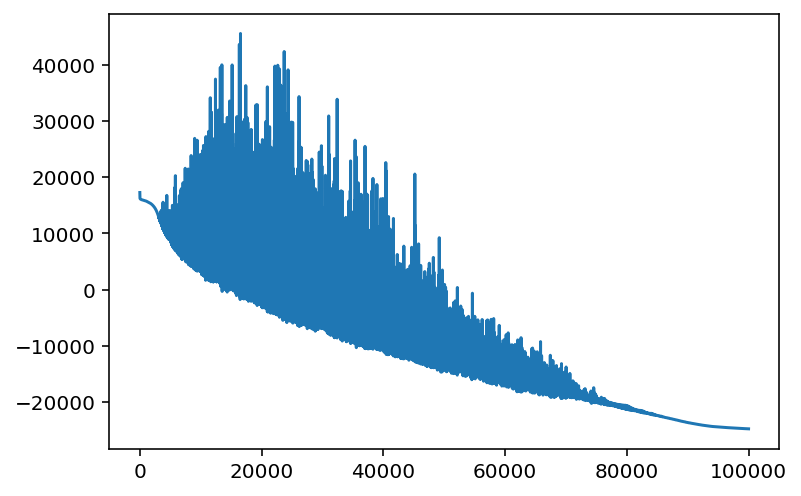

-24740.184


In [39]:
fig, ax = plt.subplots()
ax.plot(loss_sgd)
plt.show()
print(loss_sgd[-1])

## RWMH

In [46]:
%%time
step_size = 5e-5
n_blind_steps = 40_000
key = jax.random.PRNGKey(0)
# chains_rwmh, avg_accept_prob = rwmh_sampler(log_posterior_fn, params_init, key, n_samples, n_blind_steps, step_size)
chain_rwmh, avg_accept_prob = pmap_(rwmh_sampler)(x_train, y_train, params_init, log_likelihood_fn, log_prior_fn, n_dev, key, n_samples, n_blind_steps, step_size)
jnp.save('tmp/rwmh.npy', chain_rwmh)
print(f'Avg. accept. prob.: {avg_accept_prob.mean():.2%}')

Avg. accept. prob.: 87.98%
CPU times: user 29.1 s, sys: 1min 22s, total: 1min 51s
Wall time: 3min 13s


## HMC

In [47]:
%%time
step_size = 1e-6
n_leapfrog_steps = 10_000
chain_hmc, avg_accept_prob = pmap_(hmc_sampler)(x_train, y_train, params_init, log_likelihood_fn, log_prior_fn, n_dev, key, n_samples, n_leapfrog_steps, step_size)
jnp.save('tmp/hmc.npy', chain_hmc)
print(f'Avg. accept. prob.: {avg_accept_prob.mean():.2%}')

Avg. accept. prob.: 90.00%
CPU times: user 20.7 s, sys: 55.1 s, total: 1min 15s
Wall time: 2min 10s


## NUTS

In [ ]:
%%time
step_size = 1e-6
max_depth = 13
print('max leapfrog steps: ', 2**max_depth)
key = jax.random.PRNGKey(0)
chain_nuts, ratio_valid_samples, total_stops = pmap_(nuts_sampler)(x_train, y_train, params_init, log_likelihood_fn, log_prior_fn, n_dev, key, n_samples, max_depth, step_size)
jnp.save('tmp/nuts.npy', chain_nuts)
print(f'Proportion valid: {ratio_valid_samples.mean():.2%}')
print(f'Termination: max_steps={total_stops[0]}, u-turn={total_stops[1]}, max_error={total_stops[2]}.')


max leapfrog steps:  8192


## ensamble

In [ ]:
%%time
ens_size = 10
key = jax.random.PRNGKey(0)
chain_ens = init_sd*jax.random.normal(key, [ens_size, n_params])
chain_ens, loss_history = pmap_(train_ensamble)(x_train, y_train, chain_ens, log_likelihood_fn, log_prior_fn, n_dev, n_epochs, lr_start, lr_stop)
jnp.save('tmp/ens.npy', chain_ens)

## save training output

In [44]:
chains_dict = {
    'sgd': chain_sgd,
    'ensamble': chain_ens,
    'rwmh': chain_rwmh,
    'hmc': chain_hmc,
    'nuts': chain_nuts,
}

In [ ]:
os.makedirs('tmp', exist_ok=True)
with open('tmp/chains_dict.npy', 'wb') as file:
    pickle.dump(chains_dict, file)

# load training output

In [ ]:
with open('tmp/chains_dict.npy', 'rb') as file:
    chains_dict = pickle.load(file)

In [ ]:
for name, chains in chains_dict.items():
    print(name, chains.shape)

# burn-in

In [ ]:
burn_in = 20
for name in chains_dict.keys():
    if chains_dict[name].shape[1] > 50:
        chains_dict[name] = chains_dict[name][:, burn_in:]

# diagnostics

## history of a single parameter

In [ ]:
chain_idx = 0
param_idx = 0
n_points = 100
y_range = 0.07
fig, axs = plt.subplots(3, 1, figsize=[8, 5])
axs = axs.flatten()
chains_to_show = ['rwmh', 'hmc', 'nuts']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    param = chains[chain_idx, :, param_idx]
    axs[i].plot(param[:n_points].tolist(), 'o-', alpha=0.8, label=name, color=f'C{i}')
    y_mean = chains[chain_idx, :, param_idx].mean()
    axs[i].axhline(y=y_mean, linestyle="--", color='black')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_ylim([y_mean-y_range, y_mean+y_range])
    axs[i].legend()
    axs[i].set_ylabel('value')
    if i == 2: axs[i].set_xlabel('step')
plt.tight_layout()
# plt.savefig('plots/mh_parameter_history.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## autocorrelation

In [ ]:
fig, ax = plt.subplots()

# autocorrelation
chains_to_show = ['rwmh', 'hmc', 'nuts']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    r = metrics.autocorr(chains, 10)
    ax.plot(r.tolist(), 'o-', alpha=0.8, label=name)
    # ax.axhline(y=0, color='black', linestyle="--")
ax.legend()
ax.set_xlabel('lag')
ax.set_ylabel('autocorrelation')

# plt.savefig('plots/rhat_autocorr.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## $\hat{R}$

In [ ]:
fig, ax = plt.subplots()

# R_hat
chains_to_show = ['rwmh', 'hmc', 'nuts']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    r = metrics.r_hat(chains)
    ax.scatter([i]*len(r), r.tolist(), alpha=0.5)
    ax.scatter(i, r.mean(), color='black', marker='x', s=200, zorder=2)
ax.set_xticks(range(len(chains_to_show)))
ax.set_xticklabels(chains_to_show)
ax.set_ylabel('R_hat in weight space')
ax.axhline(y=1, color='black', linestyle="--")

# plt.savefig('plots/rhat_autocorr.pdf', bbox_inches='tight', pad_inches=0)
# ax.set_yscale('log')
# ax.set_ylim([0.99, 1.16])
plt.show()

## calibration

In [ ]:
# residuals

def get_std_resid(chain):
    # average y_hat across nodes
    predict_vmap = jax.vmap(predict_fn, [None, 0])
    y_hat = predict_vmap(x_test, chain).mean(0)
    mean, std = y_hat[:, 0], y_hat[:, 1]

    # compute residuals
    std_resid = (y_test - mean) #/ std

    return std_resid

fig, axs = plt.subplots(2, 3, figsize=[8, 6])
axs = axs.flatten()
for i, (name, chains) in enumerate(chains_dict.items()):    
    std_resid = jax.vmap(get_std_resid)(chains).flatten()
    # x_ = jnp.linspace(-3, 3, 500)
    # y_ = jax.scipy.stats.norm.pdf(x_)
    # axs[i].plot(x_, y_, color='black')
    axs[i].hist(std_resid.tolist(), bins=100, density=True, label=name, color=f'C{i}')
    axs[i].set_xlim([-2, 2])
    axs[i].set_ylim([0, 5])
    axs[i].legend()

axs[-1].axis('off')
plt.show()

## Brier score

In [ ]:
for i, (name, chains) in enumerate(chains_dict.items()):
    
    def mse_fn(chain):
        # average y_hat across nodes
        predict_vmap = jax.vmap(predict_fn, [None, 0])
        y_hat = predict_vmap(x_test, chain).mean(0)
        mean, std = y_hat[:, 0], y_hat[:, 1]
        
        # compute mean error
        mse = ((y_test - mean)**2).mean()
        return mse
    
    # compute mse for each chain
    mse_vmap = jax.vmap(mse_fn, 0)
    mse = mse_vmap(chains)
    print(f'{name}, {mse.mean():.3f} ± {mse.std():.4f}')

## Likelihood of test data

In [ ]:
def chain_to_loglike(chain):
    # compute y_hat for each node in the chain
    test_loglike_fn = distributions.make_gaussian_log_likelihood(x_test, y_test, predict_fn)
    log_likelihood = jax.vmap(test_loglike_fn)(chain)

    # average the likelihood across nodes
    log_likelihood = jax.scipy.special.logsumexp(log_likelihood, 0) - jnp.log(len(chain))

    # get total likelihood of all data points
    log_likelihood = log_likelihood.sum()
    return log_likelihood

for i, (name, chains) in enumerate(chains_dict.items()):    
    ll = jax.vmap(chain_to_loglike)(chains)
    print(f'{name}: {ll.mean():.3f} ± {ll.std():.4f}')

## Distribution of parameters

In [ ]:
fig, ax = plt.subplots(figsize=[9, 4])
d = 10 # num. of params to plot
chains_to_show = ['sgd', 'rwmh', 'hmc', 'nuts']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    M, N, D = chains.shape
    y_ = chains.reshape([M*N, D])[:, :d]
    x_ = jnp.zeros([len(y_), 1]) + jnp.arange(d)[None] + (0.2*i - 0.3)
    ax.scatter(x_, y_, c=f'C{i}', alpha=1, label=name)

for i in range(d-1):
    ax.axvline(x=i+0.5, linestyle="--", color='black')

ax.set_xlim([-0.5, d-0.5])
ax.set_xticks(range(d))
ax.set_xlabel('Parameter index')
ax.set_ylabel('Sampled values')
ax.legend(loc='lower left')
# plt.savefig('plots/parameter_distribution.pdf', bbox_inches='tight', pad_inches=0)
plt.show()